In [1]:
import numpy as np
import pandas as pd

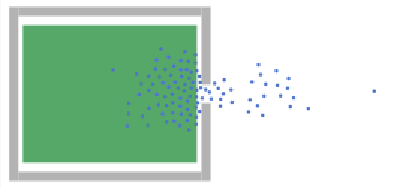

In [2]:
df = pd.read_csv('datasets/postvis.traj', delim_whitespace=True)
traj = np.array(df,dtype=float)
# 8 columns
# 0-pedId, 1-simTime, 2-endTime, 3-startX, 4-startY, 5-endX, 6-endY, 7-targetId
df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,1.045379,8.577139,8.601742,9.397920,8.601742,6
1,2,0.400000,1.193789,5.969761,12.684033,6.626429,12.684033,6
2,3,0.400000,1.206596,9.103012,14.466950,9.579383,14.146795,6
3,4,0.400000,0.928872,7.217410,19.891623,7.217410,19.891623,6
4,5,0.400000,1.065057,12.435188,7.360020,13.051691,7.893366,6
...,...,...,...,...,...,...,...,...
13945,2,148.838539,149.632328,98.853520,13.398475,98.853520,13.398475,6
13946,84,149.468092,150.119044,98.851604,10.222867,98.851604,10.222867,6
13947,26,149.600804,150.458280,98.854324,11.796297,98.854324,11.796297,6
13948,3,149.620267,150.426863,98.851561,14.862657,98.851561,14.862657,6


In [3]:
# analyse first 104 time step
sim_step = 104
step_length = 0.4

data_cm = np.zeros((sim_step, 2))

for t in range(sim_step):
    i = np.where((traj[:,1] > step_length*t) & (traj[:,1] <= step_length*(t+1)))
    if np.isnan(i).all():
        data_cm[t,:] = data_cm[t-1,:]
        continue       
    data_cm[t,0] = np.average(traj[i,3])
    data_cm[t,1] = np.average(traj[i,4])

In [4]:
X = data_cm[:-1,:]
Y = data_cm[1:,:]

In [5]:
X

array([[12.42087736, 14.42726513],
       [12.42087736, 14.42726513],
       [13.02798085, 14.45715892],
       [13.80042699, 14.78729425],
       [13.65109688, 14.46996282],
       [14.58722505, 14.04330832],
       [14.91818709, 14.56352508],
       [15.63757335, 14.43098724],
       [15.04009868, 14.58799582],
       [16.31079094, 14.37586029],
       [16.03175355, 14.00154539],
       [16.97373091, 14.64393226],
       [16.82329514, 14.32796866],
       [17.63098972, 14.11322523],
       [18.16524358, 14.50926019],
       [17.84433867, 14.35002238],
       [18.53037378, 14.07396755],
       [18.78471529, 14.4549849 ],
       [19.25819246, 14.37990567],
       [19.3656259 , 14.28340533],
       [20.04588507, 14.22901493],
       [20.54492608, 14.38688097],
       [20.08824303, 14.35366767],
       [21.0352844 , 14.47208521],
       [21.14495025, 14.11581068],
       [21.73804902, 14.09096671],
       [21.61095105, 14.51882341],
       [22.19576185, 14.38065769],
       [22.62270119,